In [5]:
import numpy as np
import tensorflow as tf

class MultiLayerRNN:
    def __init__(self, n_inputs, n_hidden_layers, n_hidden_units, n_output, lr=0.001):
        self.n_inputs = n_inputs
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_output = n_output
        self.lr = lr

        self.U = [tf.Variable(tf.random.normal((n_hidden_units, n_inputs), stddev=0.01)) for _ in range(n_hidden_layers)]
        self.W = [tf.Variable(tf.random.normal((n_hidden_units, n_hidden_units), stddev=0.01)) for _ in range(n_hidden_layers)]
        self.V = tf.Variable(tf.random.normal((n_output, n_hidden_units), stddev=0.01))
        self.b = [tf.Variable(tf.zeros((n_hidden_units, 1))) for _ in range(n_hidden_layers)]
        self.c = tf.Variable(tf.zeros((n_output, 1)))

    def forward(self, X):
        T = X.shape[0]
        self.h = [tf.zeros((T, self.n_hidden_units)) for _ in range(self.n_hidden_layers)]
        self.y = tf.zeros((T, self.n_output))

        for t in range(T):
            self.h[0][t] = tf.tanh(tf.matmul(self.U[0], X[t]) + tf.matmul(self.W[0], self.h[0][t-1]) + self.b[0])
            for l in range(1, self.n_hidden_layers):
                self.h[l][t] = tf.tanh(tf.matmul(self.U[l], self.h[l-1][t]) + tf.matmul(self.W[l], self.h[l][t-1]) + self.b[l])
            self.y[t] = tf.matmul(self.V, self.h[-1][t]) + self.c

        return self.y

    def backward(self, X, y, y_pred):
        T = X.shape[0]
        dU = [tf.zeros_like(self.U[l]) for l in range(self.n_hidden_layers)]
        dW = [tf.zeros_like(self.W[l]) for l in range(self.n_hidden_layers)]
        dV = tf.zeros_like(self.V)
        db = [tf.zeros_like(self.b[l]) for l in range(self.n_hidden_layers)]
        dc = tf.zeros_like(self.c)

        dh_next = [tf.zeros_like(self.h[0][0]) for _ in range(self.n_hidden_layers)]

        for t in reversed(range(T)):
            dy = y_pred[t] - y[t]
            dV += tf.linalg.matmul(dy, tf.transpose(self.h[-1][t]))
            dc += dy

            dh = tf.linalg.matmul(tf.transpose(self.V), dy) + dh_next[-1]
            dh_raw = (1 - self.h[-1][t] ** 2) * dh
            db[-1] += dh_raw
            dU[-1] += tf.linalg.matmul(dh_raw, tf.transpose(self.h[-2][t]))
            dW[-1] += tf.linalg.matmul(dh_raw, tf.transpose(self.h[-1][t-1]))
            dh_next[-1] = tf.linalg.matmul(tf.transpose(self.W[-1]), dh_raw)

            for l in reversed(range(self.n_hidden_layers - 1)):
                dh = dh_next[l+1] + tf.linalg.matmul(tf.transpose(self.U[l+1]), dh_raw)
                dh_raw = (1 - self.h[l][t] ** 2) * dh
                db[l] += dh_raw
                dU[l] += tf.linalg.matmul(dh_raw, X[t] if l == 0 else tf.transpose(self.h[l-1][t]))
                dW[l] += tf.linalg.matmul(dh_raw, tf.transpose(self.h[l][t-1]))
                dh_next[l] = tf.linalg.matmul(tf.transpose(self.W[l]), dh_raw)

        for dparam in dU + dW + db + [dV, dc]:
            dparam = tf.clip_by_value(dparam, -1, 1)

        for l in range(self.n_hidden_layers):
            self.U[l] -= self.lr * dU[l]
            self.W[l] -= self.lr * dW[l]
            self.b[l] -= self.lr * db[l]
        self.V -= self.lr * dV
        self.c -= self.lr * dc

    def train(self, X_train, y_train, n_epochs=1000):
        for epoch in range(n_epochs):
            for X, y in zip(X_train, y_train):
                y_pred = self.forward(X)
                self.backward(X, y, y_pred)
            if epoch % 100 == 0:
                loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_train, logits=self.predict(X_train)))
                print(f'Epoch {epoch}, Loss: {loss}')

    def predict(self, X):
        y_pred = [self.forward(x) for x in X]
        return tf.concat(y_pred, axis=0)


In [6]:
class MultiLayerRNN:
    def __init__(self, n_inputs, n_hidden_layers, n_hidden_units, n_output, lr=0.001):
        self.n_inputs = n_inputs
        self.n_hidden_layers = n_hidden_layers
        self.n_hidden_units = n_hidden_units
        self.n_output = n_output
        self.lr = lr

        self.U = [np.random.randn(n_hidden_units, n_inputs) * 0.01] + \
                 [np.random.randn(n_hidden_units, n_hidden_units) * 0.01 for _ in range(n_hidden_layers - 1)]
        self.W = [np.random.randn(n_hidden_units, n_hidden_units) * 0.01 for _ in range(n_hidden_layers)]
        self.V = np.random.randn(n_output, n_hidden_units) * 0.01
        self.b = [np.zeros((n_hidden_units, 1)) for _ in range(n_hidden_layers)]
        self.c = np.zeros((n_output, 1))

    def forward(self, X):
        T = X.shape[0]
        self.h = [np.zeros((T, self.n_hidden_units)) for _ in range(self.n_hidden_layers)]
        self.y = np.zeros((T, self.n_output))

        for t in range(T):
            self.h[0][t] = np.tanh(np.dot(self.U[0], X[t]) + np.dot(self.W[0], self.h[0][t-1]) + self.b[0])
            for l in range(1, self.n_hidden_layers):
                self.h[l][t] = np.tanh(np.dot(self.U[l], self.h[l-1][t]) + np.dot(self.W[l], self.h[l][t-1]) + self.b[l])
            self.y[t] = np.dot(self.V, self.h[-1][t]) + self.c

        return self.y


In [7]:
    def backward(self, X, y, y_pred):
        T = X.shape[0]
        dU = [np.zeros_like(self.U[l]) for l in range(self.n_hidden_layers)]
        dW = [np.zeros_like(self.W[l]) for l in range(self.n_hidden_layers)]
        dV = np.zeros_like(self.V)
        db = [np.zeros_like(self.b[l]) for l in range(self.n_hidden_layers)]
        dc = np.zeros_like(self.c)

        dh_next = [np.zeros_like(self.h[0][0]) for _ in range(self.n_hidden_layers)]

        for t in reversed(range(T)):
            dy = y_pred[t] - y[t]
            dV += np.outer(dy, self.h[-1][t])
            dc += dy

            dh = np.dot(self.V.T, dy) + dh_next[-1]
            dh_raw = (1 - self.h[-1][t] ** 2) * dh
            db[-1] += dh_raw
            dU[-1] += np.outer(dh_raw, self.h[-2][t])
            dW[-1] += np.outer(dh_raw, self.h[-1][t-1])
            dh_next[-1] = np.dot(self.W[-1].T, dh_raw)

            for l in reversed(range(self.n_hidden_layers - 1)):
                dh = dh_next[l+1] + np.dot(self.U[l+1].T, dh_raw)
                dh_raw = (1 - self.h[l][t] ** 2) * dh
                db[l] += dh_raw
                dU[l] += np.outer(dh_raw, X[t] if l == 0 else self.h[l-1][t])
                dW[l] += np.outer(dh_raw, self.h[l][t-1])
                dh_next[l] = np.dot(self.W[l].T, dh_raw)

        for dparam in dU + dW + db + [dV, dc]:
            np.clip(dparam, -1, 1, out=dparam)

        for l in range(self.n_hidden_layers):
            self.U[l] -= self.lr * dU[l]
            self.W[l] -= self.lr * dW[l]
            self.b[l] -= self.lr * db[l]
        self.V -= self.lr * dV
        self.c -= self.lr * dc


In [8]:
    def train(self, X_train, y_train, n_epochs=1000):
        for epoch in range(n_epochs):
            for X, y in zip(X_train, y_train):
                y_pred = self.forward(X)
                self.backward(X, y, y_pred)
            if epoch % 100 == 0:
                loss = CrossEntropy()(y_train, self.predict(X_train))
                print(f'Epoch {epoch}, Loss: {loss}')

    def predict(self, X):
        y_pred = [self.forward(x) for x in X]
        return np.array(y_pred).squeeze()


In [11]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (100, 10, 1)
y_train shape: (100, 10, 1)


In [17]:
def train(self, X_train, y_train, n_epochs=1000):
    losses = []
    for epoch in range(n_epochs):
        epoch_loss = 0
        for X, y in zip(X_train, y_train):
            y_pred = self.forward(X)
            loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred))
            self.backward(X, y, y_pred)
            epoch_loss += loss
        losses.append(epoch_loss)
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {epoch_loss}')
    return losses


In [26]:
def forward(self, X):
    T = X.shape[0]
    self.h = [tf.zeros((T, self.n_hidden_units)) for _ in range(self.n_hidden_layers)]
    self.y = tf.zeros((T, self.n_output))

    for t in range(T):
        self.h[0][t] = tf.tanh(tf.matmul(self.U[0], X[t]) + tf.matmul(self.W[0], self.h[0][t-1]) + self.b[0])
        for l in range(1, self.n_hidden_layers):
            self.h[l][t] = tf.tanh(tf.matmul(self.U[l], self.h[l-1][t]) + tf.matmul(self.W[l], self.h[l-1][t-1]) + self.b[l])
        self.y[t] = tf.matmul(self.V, self.h[-1][t]) + self.c

    return self.y


在這個forward方法中，使用了一個迴圈來遍歷序列中的每個時間步。在每個時間步中，模型將訊息通過多個隱藏層來處理，這就是多層級結構的體現。在內部迴圈中，遍歷了每個隱藏層，對於每一層都使用當前隱藏層的輸出來計算下一層隱藏層的輸出，所以這個程式中的「多層級」主要體現在模型的前向傳播過程中，通過多個隱藏層來處理訊息。

NameError: name 'predictions' is not defined

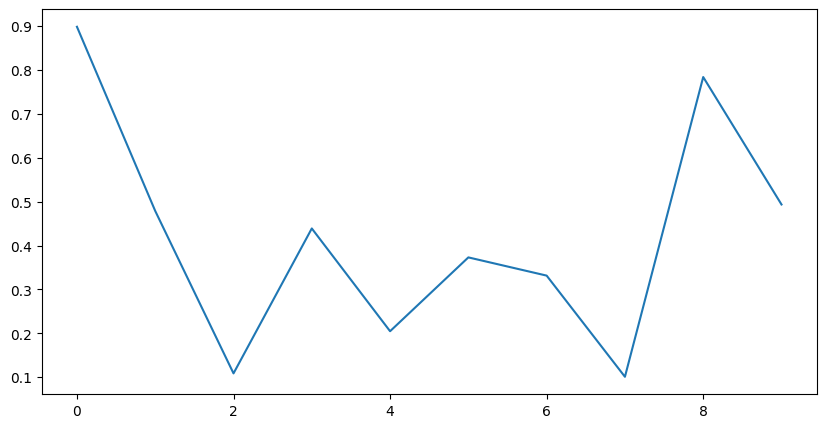

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 隨機選擇一些序列來展示
num_samples = 3
sample_indices = np.random.choice(len(X_train), num_samples, replace=False)

# 繪製每個序列的預測結果
for i, idx in enumerate(sample_indices):
    plt.figure(figsize=(10, 5))
    plt.plot(y_train[idx], label='Actual')
    plt.plot(predictions[idx], label='Predicted')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(f'Sequence {idx + 1} Prediction')
    plt.legend()
    plt.show()
